In [46]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import spatial
import networkx as nx
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix

In [8]:
DATA_PATH = "lalonde.csv"
df_original = pd.read_csv(DATA_PATH)
df_original.treat.value_counts()
df_original.head()

id  treat  age  educ  black  hispan  married  nodegree  re74  re75  \
0  NSW1      1   37    11      1       0        1         1   0.0   0.0   
1  NSW2      1   22     9      0       1        0         1   0.0   0.0   
2  NSW3      1   30    12      1       0        0         0   0.0   0.0   
3  NSW4      1   27    11      1       0        0         1   0.0   0.0   
4  NSW5      1   33     8      1       0        0         1   0.0   0.0   

         re78  
0   9930.0460  
1   3595.8940  
2  24909.4500  
3   7506.1460  
4    289.7899

# Question 1

### Part 1

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [9]:
df_part1 = df_original[['treat', 're78']].copy()

df_part1_control = df_part1[df_part1.treat == 0].copy()
df_part1_test = df_part1[df_part1.treat == 1].copy()

<Container object of 12 artists>

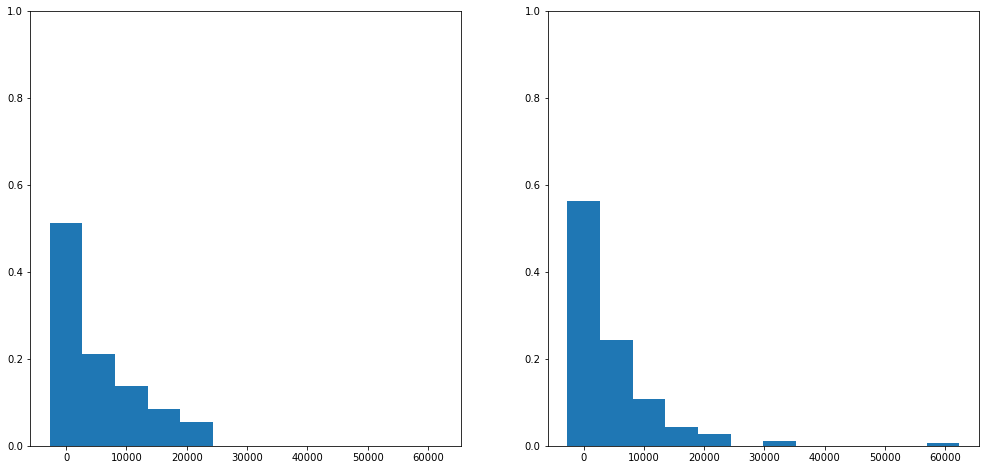

In [30]:
fix, axes = plt.subplots(1, 2, figsize=(17, 8))

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

#df_part1_control.re78.hist(ax=axes[0])
#df_part1_test.re78.hist(ax=axes[1])

results, edges = np.histogram(df_part1_control.re78, normed=True, bins=np.linspace(0, 65000, 13))
binWidth = edges[1] - edges[0]
axes[0].bar(edges[:-1], results*binWidth, binWidth)

results, edges = np.histogram(df_part1_test.re78, normed=True, bins=np.linspace(0, 65000, 13))
binWidth = edges[1] - edges[0]
axes[1].bar(edges[:-1], results*binWidth, binWidth)
#fix[1].title('Test Samples')


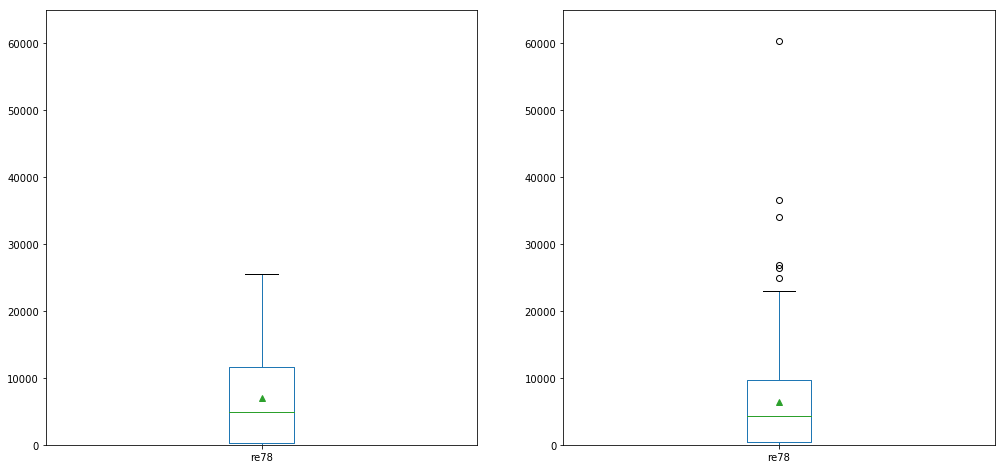

In [32]:
fix, axes = plt.subplots(1, 2, figsize=(17, 8))

axes[0].set_ylim(0, 65000)
axes[1].set_ylim(0, 65000)

df_part1_control.re78.plot.box(ax=axes[0], showmeans=True)
df_part1_test.re78.plot.box(ax=axes[1], showmeans=True)


### Part 2

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [150]:
def describeLinearData(data, column_name, separator_column, height = 8):
    data = data.copy()

    data_control = data[data[separator_column] == 0]
    data_test = data[data[separator_column] == 1]

    fix, axes = plt.subplots(2, 2, figsize=(17, height))
    plt.suptitle(column_name)
    axes[0, 0].set_title('Box plot of control set')
    axes[0, 1].set_title('Box plot of test set')
    axes[1, 0].set_title('Histogram of control set')
    axes[1, 1].set_title('Histogram of test set')

    data_control[column_name].plot.box(ax=axes[0, 0], showmeans=True)
    data_test[column_name].plot.box(ax=axes[0, 1], showmeans=True)
    
    #axes[0, 0].set_ylim(0, 65000)
    #axes[0, 1].set_ylim(0, 65000)
    axes[1, 0].set_ylim(0, 1)
    axes[1, 1].set_ylim(0, 1)

    results, edges = np.histogram(data_control[column_name], normed=True, bins=np.linspace(0, max(data_control[column_name]), 10))
    binWidth = edges[1] - edges[0]
    axes[1, 0].bar(edges[:-1], results*binWidth, binWidth)

    results, edges = np.histogram(data_test[column_name], normed=True, bins=np.linspace(0, max(data_test[column_name]), 10))
    binWidth = edges[1] - edges[0]
    axes[1, 1].bar(edges[:-1], results*binWidth, binWidth)
    
def describeBinaryData(data, column_name, separator_column):
    data = data.copy()
    tmp=data.groupby([data[column_name]])[separator_column]
    ax=tmp.value_counts().unstack(column_name).plot(kind='bar', legend=False)

    patches, labels = ax.get_legend_handles_labels()

    ax.legend(patches, ['%s 0' % column_name,'%s 1' % column_name], loc='best')

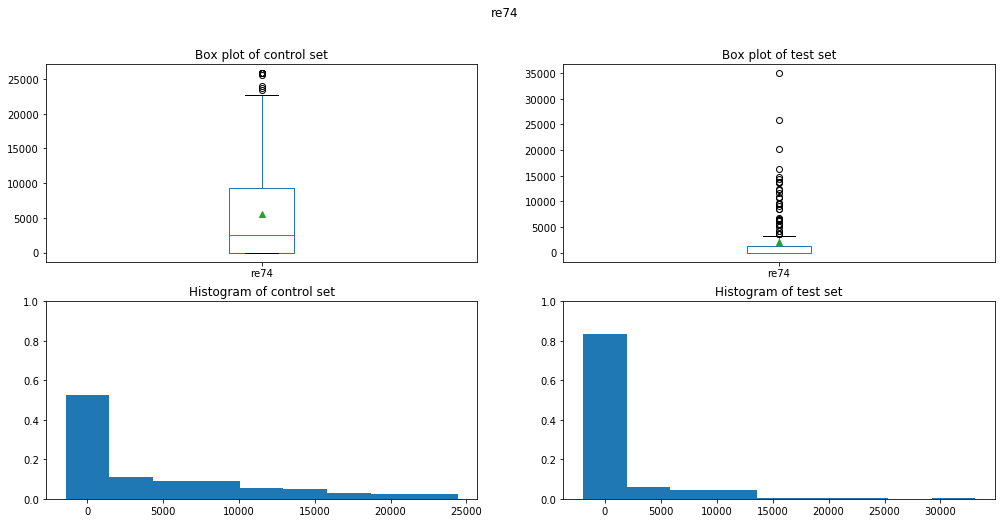

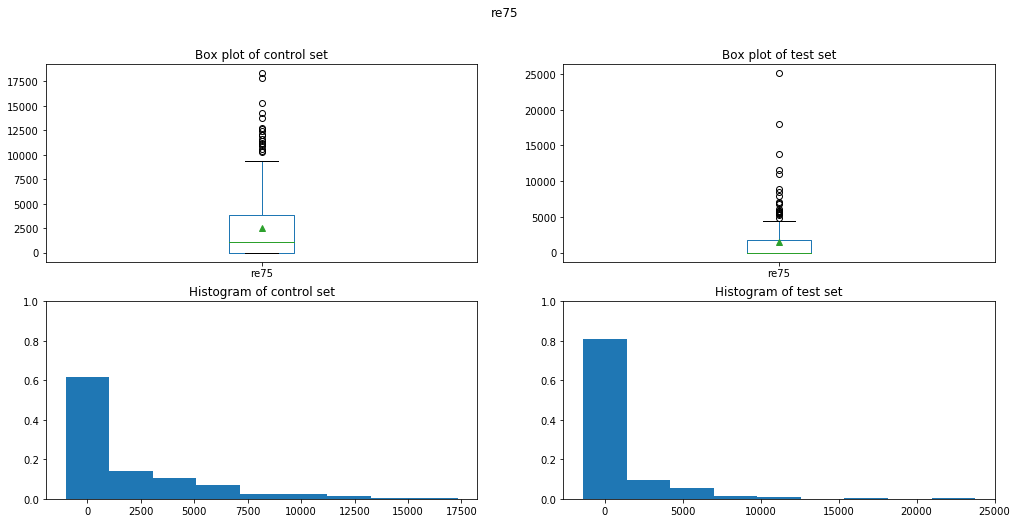

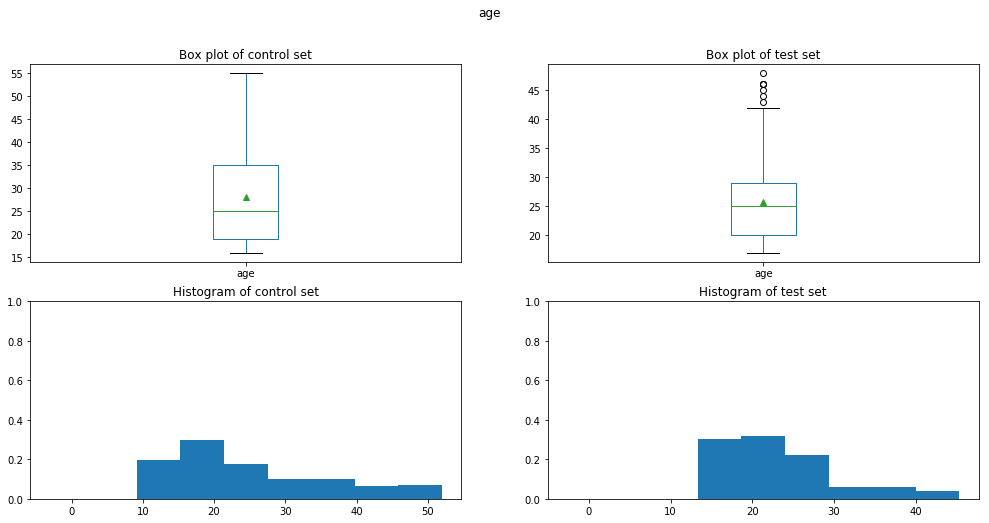

In [145]:
describeLinearData(df_original, 're74', 'treat')
describeLinearData(df_original, 're75', 'treat')
describeLinearData(df_original, 'age', 'treat')

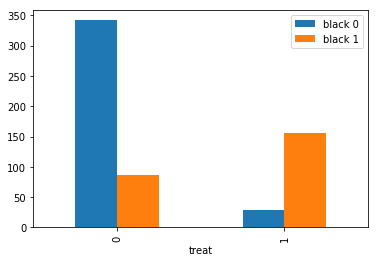

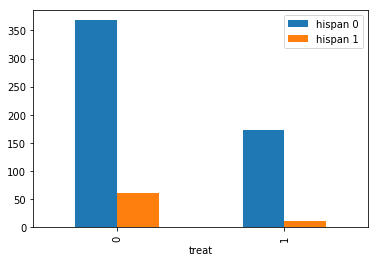

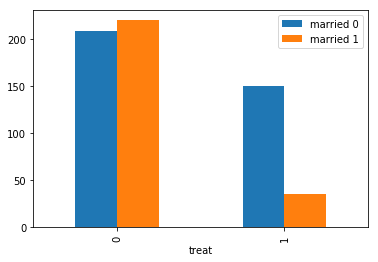

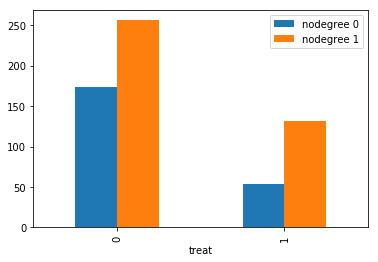

In [151]:
describeBinaryData(df_original, 'black', 'treat')
describeBinaryData(df_original, 'hispan', 'treat')
describeBinaryData(df_original, 'married', 'treat')
describeBinaryData(df_original, 'nodegree', 'treat')

### Part 3 A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores:

from sklearn import linear_model
logistic = linear_model.LogisticRegression()
Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.). To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or this article.

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups. (See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores. If you want even more information, read this article.)

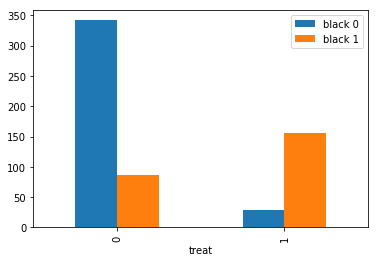

In [72]:
tmp=df_original.groupby([df_original.treat]).black
ax=tmp.value_counts().unstack('black').plot(kind='bar', legend=False)

patches, labels = ax.get_legend_handles_labels()

ax.legend(patches, ['black 0','black 1'], loc='best')

In [73]:
logistic = linear_model.LogisticRegression()

feature_columns = ['black', 'hispan', 'age', 'educ', 'married','nodegree', 're74', 're75']
X = df_original[feature_columns]
Y = df_original.treat

logistic.fit(X, Y)

for f in range(len(feature_columns)):
    print("{0} * {1} + ".format(logistic.coef_[0][f], feature_columns[f]))
print(logistic.intercept_)

2.6807554367730386 * black + 
0.5735450376603287 * hispan + 
-0.003789067733093282 * age + 
-0.019034833101165268 * educ + 
-0.7743287166826344 * married + 
-0.13970795651830636 * nodegree + 
-7.291566699983259e-05 * re74 + 
5.054152644729439e-05 * re75 + 
[-1.47713893]


In [74]:
prediction = logistic.predict_proba(X)
df_original['d0'] = np.array(prediction)[:, 0]
df_original['d1'] = np.array(prediction)[:, 1]

### Part 4 Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

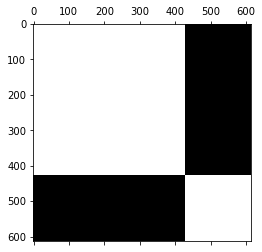

In [104]:
propensity_scores = df_original.sort_values(by='treat')[['d0']]
nb_tested = len(df_part1_test)

distances = spatial.distance.squareform(spatial.distance.pdist(propensity_scores.values, 'euclidean'))
kernel_width = distances.mean()
weights = np.exp(-np.square(distances/kernel_width**2))
weights[:-nb_tested, :-nb_tested] = 0
weights[-nb_tested:, -nb_tested:] = 0
plt.spy(weights)

In [105]:
result = nx.max_weight_matching(nx.Graph(weights))

In [122]:
idx_matched = propensity_scores.iloc[list(result.keys())].index.values
matched_samples = df_original.loc[idx_matched]
matched_samples.loc[idx_matched, 'matched_idx'] = list(result.values())

In [124]:
matched_samples.head()

id  treat  age  educ  black  hispan  married  nodegree      re74  \
306  PSID122      0   27     4      0       1        1         1  626.9654   
405  PSID221      0   19    12      0       0        0         0  815.0550   
409  PSID225      0   18     8      0       1        0         1    0.0000   
410  PSID226      0   39    10      1       0        0         1  844.4440   
411  PSID227      0   17    11      0       1        0         1    0.0000   

          re75        re78        d0        d1  matched_idx  
306  3410.5650   3367.7390  0.866391  0.133609          526  
405   964.9839  12059.7300  0.856707  0.143293          510  
409   902.3226   1306.3100  0.771743  0.228257          533  
410   889.7903    701.9201  0.329779  0.670221          462  
411   873.6774   7759.5420  0.781246  0.218754          599

In [125]:
matched_samples.treat.value_counts()

1    185
0    185
Name: treat, dtype: int64

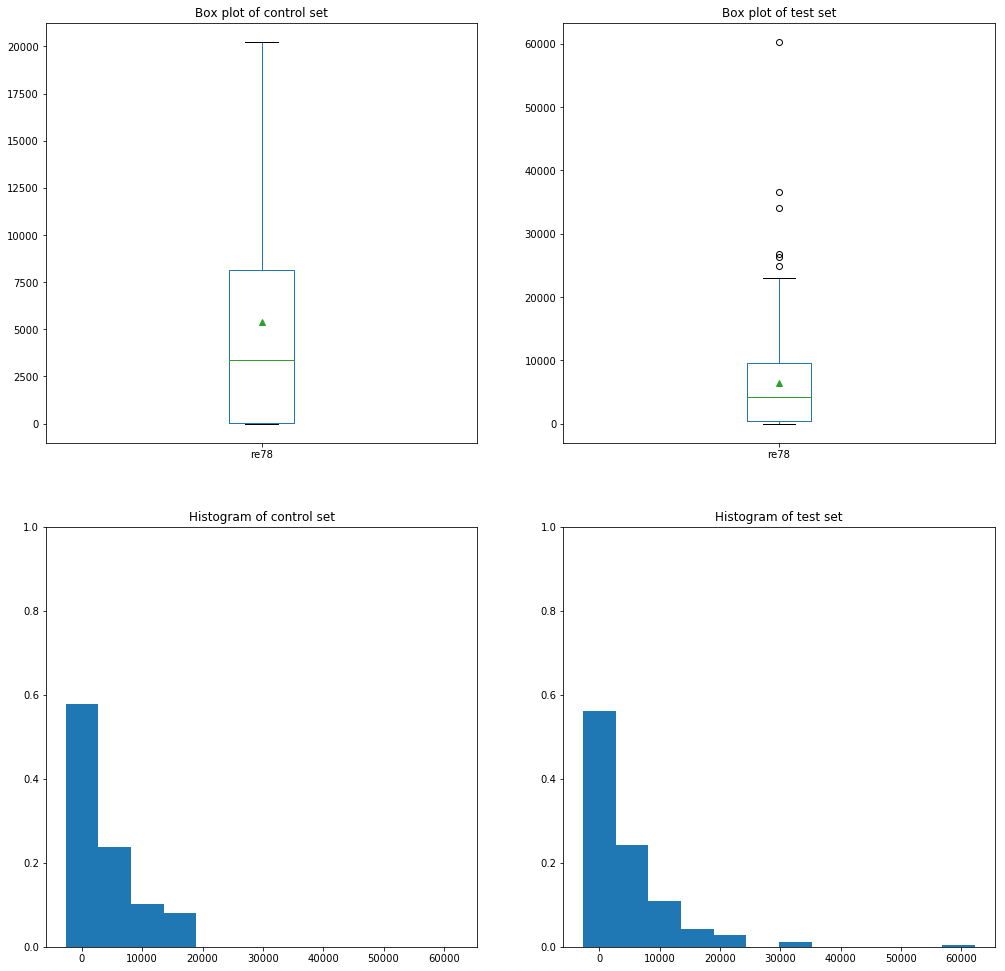

In [134]:
describeLinearData(matched_samples, 're78', 'treat', 17)

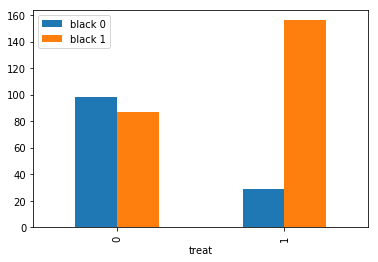

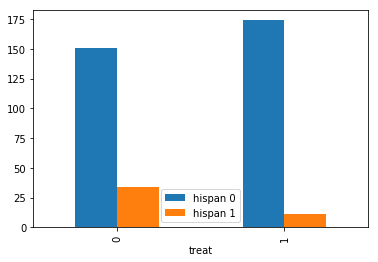

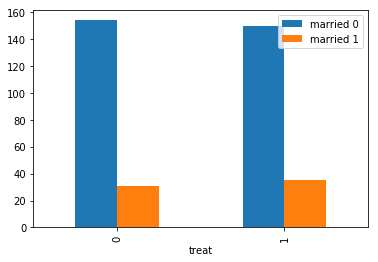

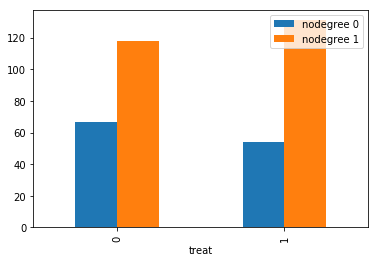

In [152]:
describeBinaryData(matched_samples, 'black', 'treat')
describeBinaryData(matched_samples, 'hispan', 'treat')
describeBinaryData(matched_samples, 'married', 'treat')
describeBinaryData(matched_samples, 'nodegree', 'treat')

### Part 5 Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

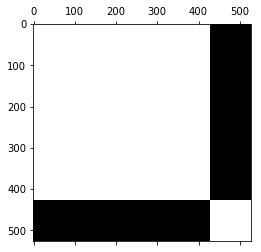

In [164]:
new_df = df_original.drop(df_original[(df_original.black == 1) & (df_original.treat == 1)]\
                       .sample(len(df_original[(df_original.black == 1) & (df_original.treat == 0)])).index.values)
propensity_scores = new_df.sort_values(by='treat')[['d0']]
nb_tested = len(new_df[new_df.treat == 1])

distances = spatial.distance.squareform(spatial.distance.pdist(propensity_scores.values, 'euclidean'))
kernel_width = distances.mean()
weights = np.exp(-np.square(distances/kernel_width**2))
weights[:-nb_tested, :-nb_tested] = 0
weights[-nb_tested:, -nb_tested:] = 0
plt.spy(weights)


In [165]:
result = nx.max_weight_matching(nx.Graph(weights))

In [166]:
idx_matched = propensity_scores.iloc[list(result.keys())].index.values
matched_samples = new_df.loc[idx_matched]
matched_samples.loc[idx_matched, 'matched_idx'] = list(result.values())

In [167]:
matched_samples.treat.value_counts()

1    98
0    98
Name: treat, dtype: int64

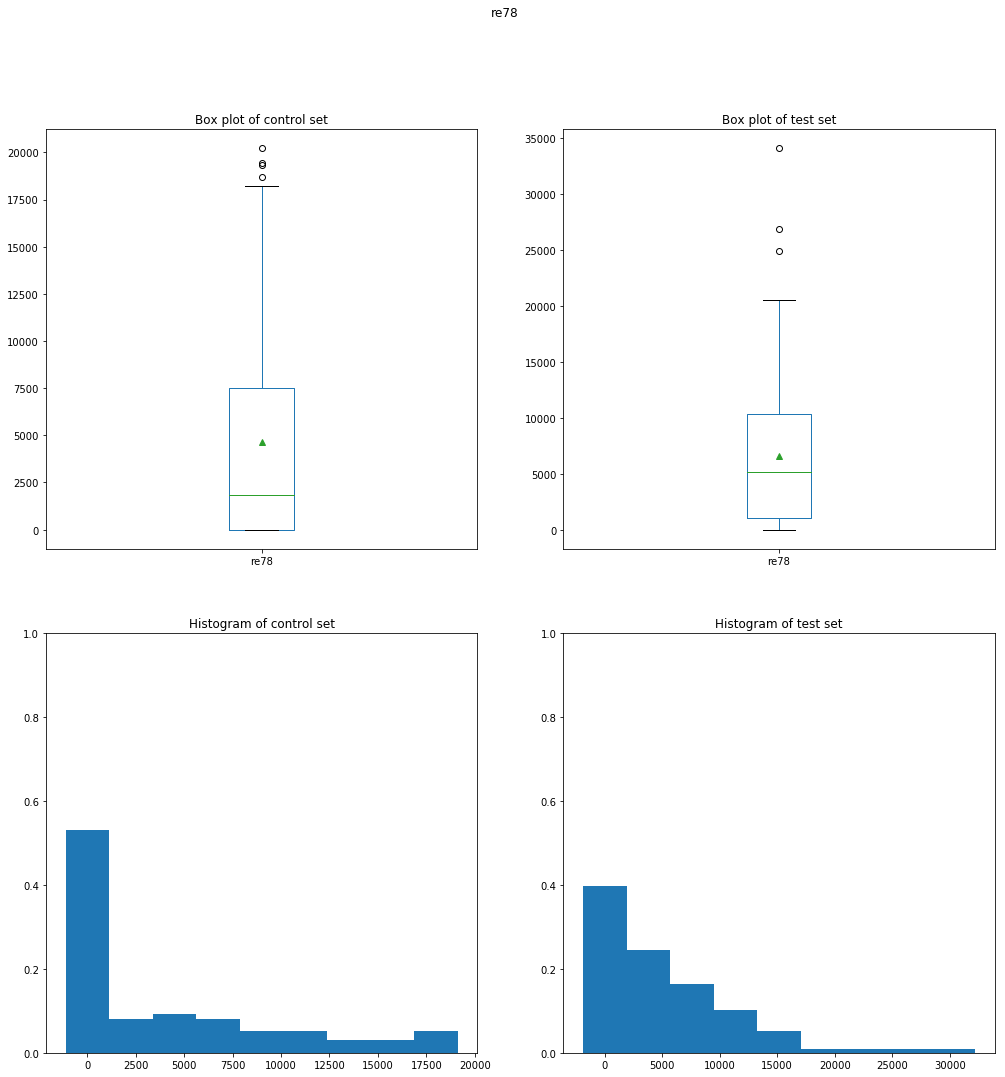

In [168]:
describeLinearData(matched_samples, 're78', 'treat', 17)

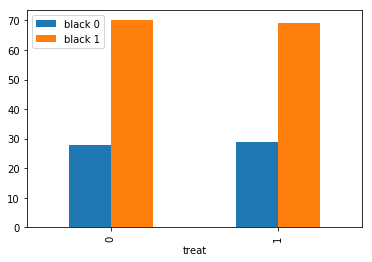

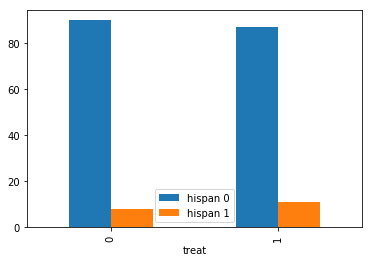

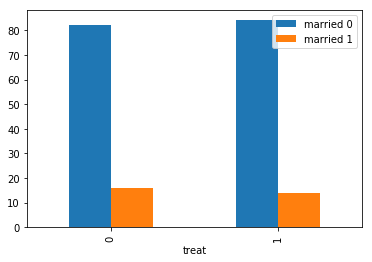

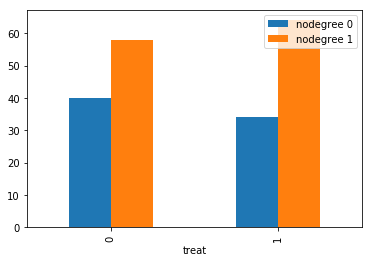

In [169]:
describeBinaryData(matched_samples, 'black', 'treat')
describeBinaryData(matched_samples, 'hispan', 'treat')
describeBinaryData(matched_samples, 'married', 'treat')
describeBinaryData(matched_samples, 'nodegree', 'treat')

# Question 2

### Part1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [23]:
newsgroups_train_file = fetch_20newsgroups()

In [39]:
newsgroups_train = newsgroups_train_file.data
newsgroups_labels = newsgroups_train_file.target
len(newsgroups_train)

11314

In [10]:
tfidf = TfidfVectorizer()

In [14]:
features = tfidf.fit_transform(newsgroups_train)

In [15]:
print(type(features))

<class 'scipy.sparse.csr.csr_matrix'>


In [26]:
features.shape

(11314, 130107)

In [40]:
from random import sample
idx = list(range(features.shape[0]))
shuffle(idx)
print(type(idx))

train = features[idx[:int(features.shape[0]*.8)], :]
train_labels = newsgroups_labels[idx[:int(features.shape[0]*.8)]]

test = features[idx[int(features.shape[0]*.8):int(features.shape[0]*.9)], :]
test_labels = newsgroups_labels[idx[int(features.shape[0]*.8):int(features.shape[0]*.9)]]


validation = features[idx[int(features.shape[0]*.9):], :]
validation_labels = newsgroups_labels[idx[int(features.shape[0]*.9):]]


<class 'list'>


## Part 2
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.

In [42]:
classifier = RandomForestClassifier(n_jobs=8, n_estimators=200, max_depth=None, verbose=True)
classifier.fit(train, train_labels)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   20.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

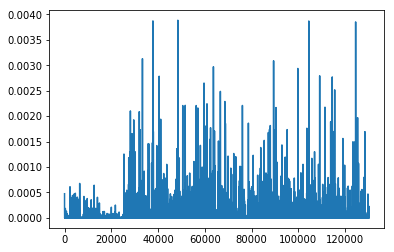

In [45]:
plt.plot(classifier.feature_importances_)

In [50]:
confusion_mx = pd.DataFrame(confusion_matrix(test_labels, classifier.predict(test)))
confusion_mx

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0   35   0   0   0   0   0   0   0   0   1   0   0   1   1   0   4   0   0   
1    0  58  11   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   
2    0   3  38   1   0   2   1   0   0   0   0   0   1   0   0   0   0   0   
3    0   1   7  50   2   0   2   0   0   1   0   0   0   0   0   1   0   0   
4    0   2   2   4  55   0   6   1   0   0   0   0   2   0   0   0   0   0   
5    0   4   2   2   0  46   0   0   0   0   0   0   0   0   1   0   0   0   
6    0   1   1   1   0   1  53   1   0   1   0   0   2   0   0   0   0   0   
7    0   3   0   1   0   2   2  51   3   1   0   0   0   0   0   0   0   0   
8    0   0   0   2   1   0   0   0  54   1   0   0   0   0   0   0   0   0   
9    0   0   1   0   0   0   1   0   0  52   3   0   0   0   0   0   0   0   
10   0   0   0   0   0   0   1   1   0   0  44   0   0   0   0   0   0   0   
11   0   1   0   1   0   2   0   0   0   0   0  59   0   0   0   0   0   0   
12   0   3   2   6   0   5   6   0   1   0   0   0  40   0   4   0   0   0   
13   0   2   0   1   0   0   0   0   0   0   0   0   1  55   0   0   0   0   
14   0   1   0   0   0   0   0   0   1   0   0   0   1   0  42   0   0   1   
15   0   1   0   0   0   0   1   0   0   1   0   0   0   1   0  58   0   1   
16   0   1   0   0   0   1   1   0   0   1   0   0   0   0   0   0  46   0   
17   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0  59   
18   0   1   0   1   0   0   0   0   0   1   0   0   0   0   1   2   3   0   
19   3   0   0   0   0   0   0   1   0   0   0   0   0   0   0  13   2   0   

    18  19  
0    0   3  
1    0   0  
2    0   0  
3    0   0  
4    0   0  
5    0   0  
6    0   0  
7    0   0  
8    0   0  
9    0   0  
10   0   0  
11   0   0  
12   0   0  
13   0   0  
14   0   0  
15   0   0  
16   0   0  
17   0   0  
18  29   0  
19   0  26